# Stage 1: Importing dependencies

In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import matplotlib.pyplot as plt
from google.colab import drive

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-cp36-none-any.whl size=30539 sha256=2690ed7c3f61d2c2a66702b84bab13930b9ada15cd965069a8f5ee685bbfed87
  Stored in directory: /root/.cache/pip/wheels/e1/f8/e2/b98f79a6b8cc898d8e4102b83acb8a098df7d27500a2bac912
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=9cc9195cd0429496434f46dd1832a52fe60347f7896fa1d4b8012da4616ede9e
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=b38b371935e68e42e60d91f45dc07ec98280f567b303eeb42d62bbb1a7a1465a
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.1MB 16.2MB/s 


In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

# Stage 2: Data preprocessing

## Loading files

We import files from our personal Google drive.

In [ ]:
# drive.mount("/content/drive")
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#cols = ["sentiment", "id", "date", "query", "user", "text"]
cols = ['label','id','date','query','user','tweet']
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/a.csv",header=None,names=cols,engine="python",encoding="latin1")

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)

In [ ]:
data.drop(["id", "date", "query", "user"],
          axis=1,
          inplace=True)

## Preprocessing

### Cleaning

In [ ]:
def clean_tweet(tweeter):
    tweeter = BeautifulSoup(tweeter, "lxml").get_text()
    # Removing the @
    tweeter = re.sub(r"@[A-Za-z0-9]+", ' ', tweeter)
    # Removing the URL links
    tweeter = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweeter)
    # Keeping only letters
    tweeter = re.sub(r"[^a-zA-Z.!?']", ' ', tweeter)
    # Removing additional whitespaces
    tweeter = re.sub(r" +", ' ', tweeter)
    return tweeter

In [ ]:
# len(data.tweet[0])

In [ ]:
data_clean = [clean_tweet(tweeter) for tweeter in data.tweet]

In [ ]:
data_labels = data.label.values
data_labels[data_labels == 4] = 1

### Tokenization

We need to create a BERT layer to have access to meta data for the tokenizer (like vocab size).

In [ ]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def encode_sentence(sent):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [ ]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]

#start from here
copyright @shawon_lodh

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def plot_model(model):
    # Plot training & validation accuracy values
    acc = model.history.history['accuracy']
    val_acc = model.history.history['val_accuracy']
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
train_valid_data, test_data, train_valid_label, test_label = train_test_split(data_inputs,data_labels, test_size=0.3, random_state=0)

In [ ]:
train_data, valid_data, train_label, valid_label = train_test_split(train_valid_data,train_valid_label, test_size=0.3, random_state=0)

In [ ]:
train_label = np.array(train_label)
valid_label = np.array(valid_label)
test_label = np.array(test_label)


In [ ]:
training_padded = pad_sequences(train_data) #truncating=trunc_type
validation_padded = pad_sequences(valid_data)
testing_padded = pad_sequences(test_data)# truncating=trunc_type

# Stage 3: Model building

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x) # batch_size, nb_filters, seq_len-1)
        x_1 = self.pool(x_1) # (batch_size, nb_filters)
        x_2 = self.trigram(x) # batch_size, nb_filters, seq_len-2)
        x_2 = self.pool(x_2) # (batch_size, nb_filters)
        x_3 = self.fourgram(x) # batch_size, nb_filters, seq_len-3)
        x_3 = self.pool(x_3) # (batch_size, nb_filters)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

# Stage 4: Training

In [ ]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [ ]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [ ]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",metrics=["accuracy"])
    # ,f1_m,precision_m, recall_m
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [ ]:
# checkpoint_path = "./drive/My Drive/Colab Notebooks/"
checkpoint_path = "gdrive/My Drive/Colab Notebooks/"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

Latest checkpoint restored!!


In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        ckpt_manager.save()
        print("Checkpoint saved at {}.".format(checkpoint_path))

In [ ]:
Dcnn.fit(training_padded, train_label, epochs=5, validation_data=(validation_padded, valid_label),batch_size=32)

Epoch 1/5
24500/24500 [==============================] - 1346s 55ms/step - loss: 0.1824 - accuracy: 0.9354 - val_loss: 0.1618 - val_accuracy: 0.9403
Epoch 2/5
24500/24500 [==============================] - 1282s 52ms/step - loss: 0.1405 - accuracy: 0.9467 - val_loss: 0.2080 - val_accuracy: 0.9354
Epoch 3/5
24500/24500 [==============================] - 1362s 56ms/step - loss: 0.1196 - accuracy: 0.9521 - val_loss: 0.1983 - val_accuracy: 0.9276
Epoch 4/5
24500/24500 [==============================] - 1333s 54ms/step - loss: 0.1067 - accuracy: 0.9560 - val_loss: 0.2454 - val_accuracy: 0.9221
Epoch 5/5
24500/24500 [==============================] - 1305s 53ms/step - loss: 0.0970 - accuracy: 0.9591 - val_loss: 0.3049 - val_accuracy: 0.9218


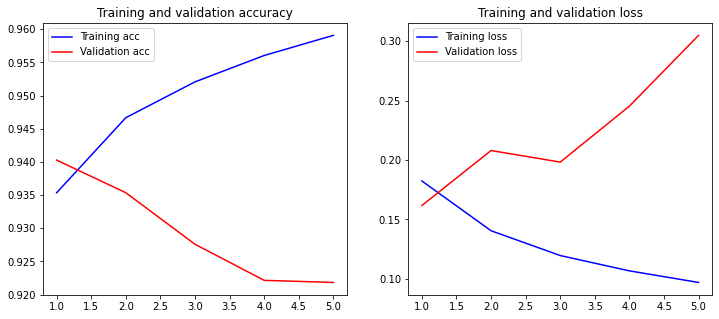

In [ ]:
plot_model(Dcnn)
# Dcnn.history.history['val_loss']

In [ ]:
results = Dcnn.predict(testing_padded)
# for i in range(len(results)):
#   results[i] = math.floor(results[i]*2)

In [ ]:
for i in range(len(results)):
  if results[i]<0.5:
    results[i] = 0
  else:
    results[i] = 1

In [ ]:
from sklearn.metrics import confusion_matrix
print('Confution matrix for test data : ')
confusion_matrix(test_label,results)

Confution matrix for test data : 


array([[223154,  16920],
       [ 21016, 218910]])

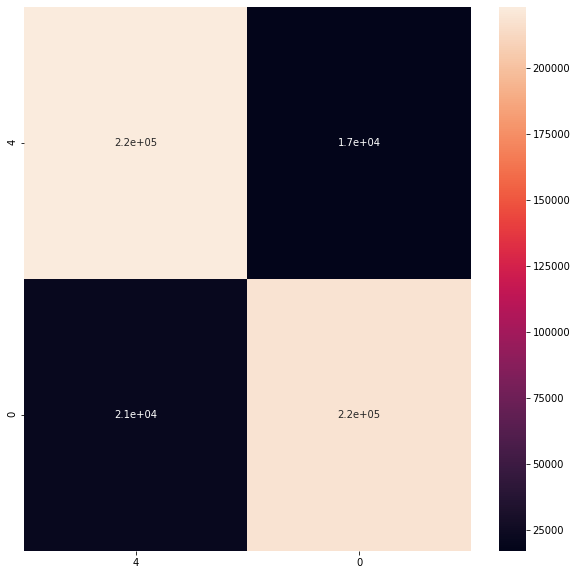

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(test_label), results)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, xticklabels=['4', '0'], yticklabels=['4', '0'])

In [ ]:
from sklearn.metrics import classification_report
print('Classification report for test data : ')
print(classification_report(test_label,results))

Classification report for test data : 
              precision    recall  f1-score   support

           0       0.91      0.93      0.92    240074
           1       0.93      0.91      0.92    239926

    accuracy                           0.92    480000
   macro avg       0.92      0.92      0.92    480000
weighted avg       0.92      0.92      0.92    480000



In [ ]:
import sklearn
sklearn.metrics.accuracy_score(test_label,results)

0.9209666666666667

In [ ]:
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6104400   
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  77056     
_________________________________________________________________
dropout (Dropout)            multiple                  0      

#Prediction one sample sentence

In [ ]:
def get_prediction(sentence):
    tokens = encode_sentence(sentence)
    inputs = tf.expand_dims(tokens, 0)

    output = Dcnn(inputs, training=False)

    sentiment = math.floor(output*2)

    if sentiment == 0:
        print("Ouput of the model: {}\nPredicted sentiment: negative.".format(
            output))
    elif sentiment == 1:
        print("Ouput of the model: {}\nPredicted sentiment: positive.".format(
            output))

In [ ]:
get_prediction("The book was good.")